In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import distributions

In [2]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x

        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)

        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [3]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [4]:
from sklearn.datasets import make_circles
def get_batch(num_samples):
    """
    Generate random points in a two concentric circles distribution.
    """
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = torch.tensor(points).type(torch.float32)
    return x

In [9]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
print("The model has {} trainable parameters".format(sum(p.numel() for p in flow.parameters() if p.requires_grad)))
for t in range(5001):    
    noisy_moons = get_batch(500)
    
    loss = -flow.log_prob(noisy_moons).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

The model has 804888 trainable parameters
iter 0: loss = 1.143


KeyboardInterrupt: 

torch.Size([30000, 2])


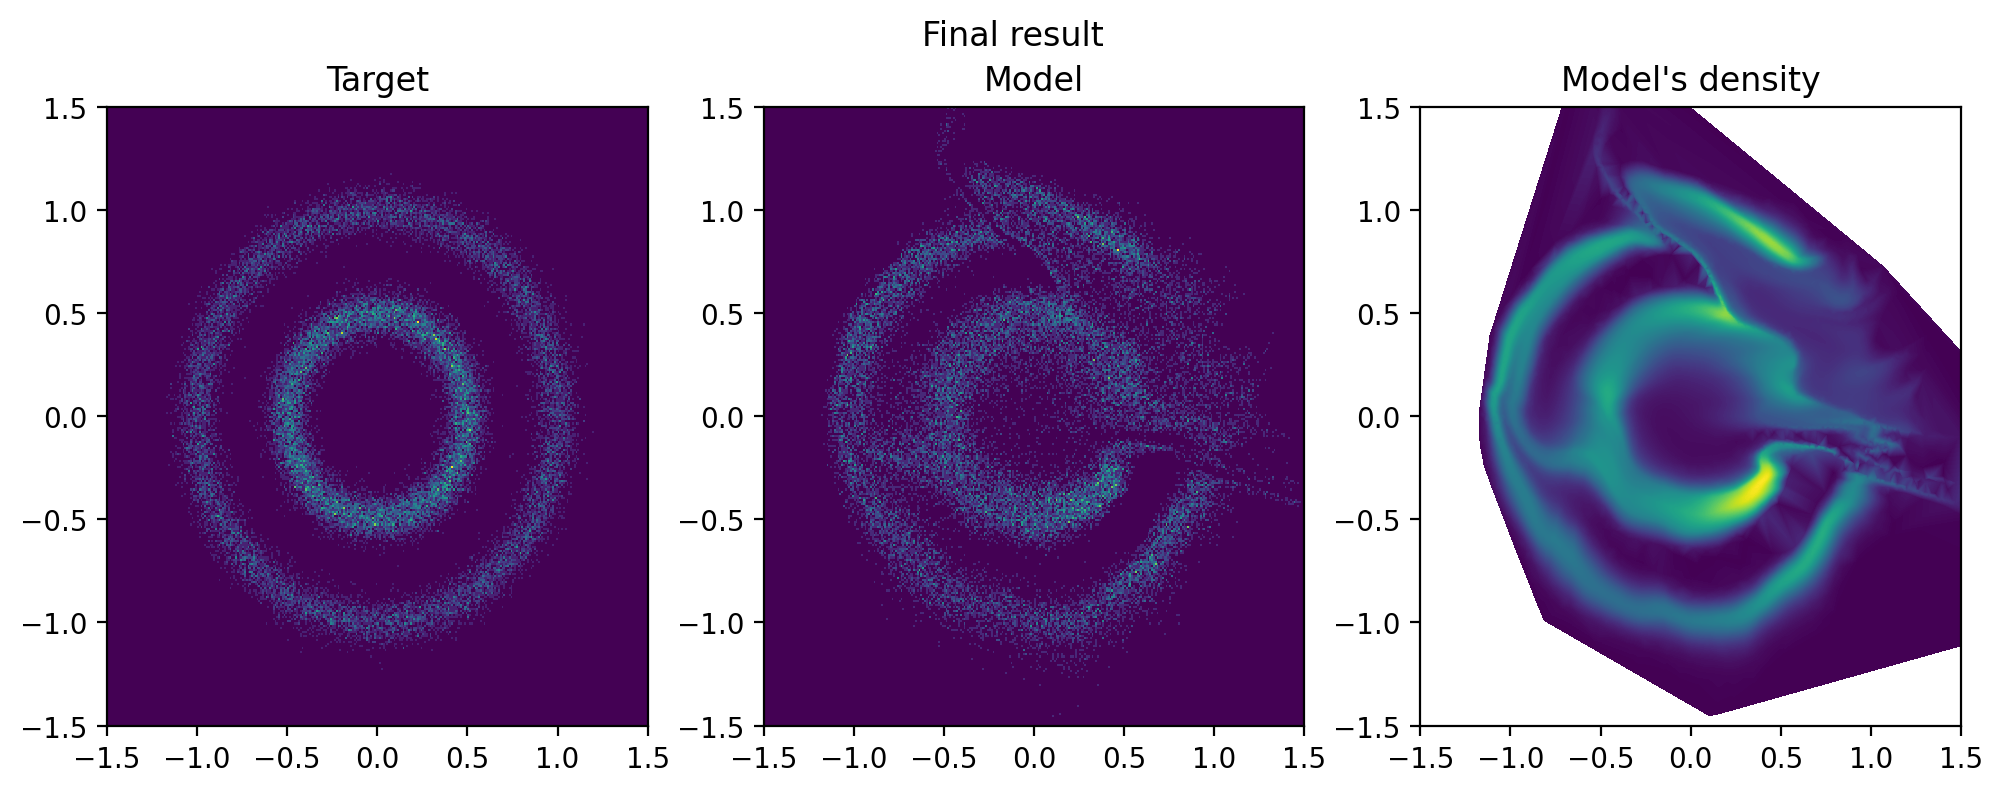

In [8]:
def nf_final(model, viz_samples = 30000):
    target = get_batch(viz_samples)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=200)
    plt.suptitle(f'Final result')
    plt.tight_layout()
    
    trans_sample = model.sample(viz_samples).view([30000,2])
    logp = model.log_prob(trans_sample)
    
    axes[0].set_title('Target')
    axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[1].set_title('Model')
    axes[1].hist2d(*trans_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[2].set_title("Model's density")
    # Set x-axis and y-axis limits
    axes[2].set_xlim(-1.5, 1.5)
    axes[2].set_ylim(-1.5, 1.5)
    axes[2].tricontourf(*trans_sample.detach().cpu().numpy().T, np.exp(logp.detach().cpu().numpy()), 200)
    
    plt.show()
    
nf_final(flow)